In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import matplotlib.pyplot as plt

In [2]:
"""
We will be analyzing the MNIST Digits Dataset, and attempt to fit a simple logistic regression model to classify whether
a given digit is '1' or '5'.

We create 2 features for an image:
- Symmetry
- Mean Intensity

We define symmetry as the as the average of the difference between an image and its flipped version along the horizontal axis,
and the difference between an image and its flipped version along the vertical axis.

We define the mean intensity as the mean intensity of the whole image.



Results:

We achieve an in sample accuracy of 96.28% and an out of sample accuracy of 82.23%
"""
#

"\nWe will be analyzing the MNIST Digits Dataset, and attempt to fit a simple logistic regression model to classify whether\na given digit is '1' or '5'.\n\nWe create 2 features for an image:\n- Symmetry\n- Mean Intensity\n\nWe define symmetry as the as the average of the difference between an image and its flipped version along the horizontal axis,\nand the difference between an image and its flipped version along the vertical axis.\n\nWe define the mean intensity as the mean intensity of the whole image.\n\n\n\nResults:\n\nWe achieve an in sample accuracy of 96.28% and an out of sample accuracy of 82.23%\n"

In [3]:
#Import and process dataframe
train = pd.read_csv("ZipDigits.train")
test = pd.read_csv("ZipDigits.test")

def process(row):
    img = row.to_numpy()
    img = np.array(img[0].split(), dtype=np.float32)
    label = int(img[0])
    img = img[1:257].reshape((16,16))
    return pd.Series({'label': label, 'img': img})
    
train = train.apply(process,axis=1)
test = test.apply(process,axis=1)

train = train[(train['label'] == 5) | (train['label'] == 1)].reset_index()

train = train.rename(columns={0: 'img'})

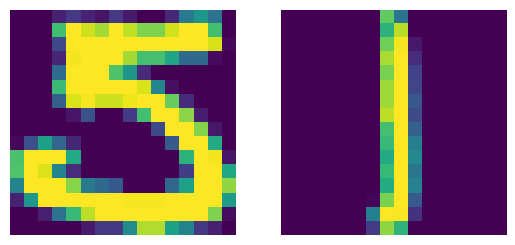

In [4]:
#Sample '1' and '5'
f, ax = plt.subplots(ncols = 2)
ax[0].imshow(train.loc[0,'img'])
ax[1].imshow(train.loc[1,'img'])
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [5]:
#Define features of the image (Symmetry and Mean Intensity)
train['mean_intensity'] = train['img'].apply(lambda x: np.mean(x))
train['symmetry'] = train['img'].apply(lambda x: -np.mean([np.abs(x-np.flip(x,axis=1)), np.abs(x-np.flip(x,axis=0))]))
train

,index,label,img,mean_intensity,symmetry
0,0,5,"[[-1.0, -1.0, -1.0, -0.813, -0.671, -0.809, -0...",-0.111738,-0.687102
1,6,1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0....",-0.753914,-0.088484
2,8,1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0...",-0.772281,-0.116422
3,11,1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.998, ...",-0.769258,-0.048250
4,12,1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0....",-0.795438,-0.047352
...,...,...,...,...,...
1556,7268,5,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",-0.289414,-0.585344
1557,7270,5,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0...",-0.534238,-0.552977
1558,7283,1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0...",-0.609793,-0.152242
1559,7284,1,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -0.744, ...",-0.662309,-0.072781


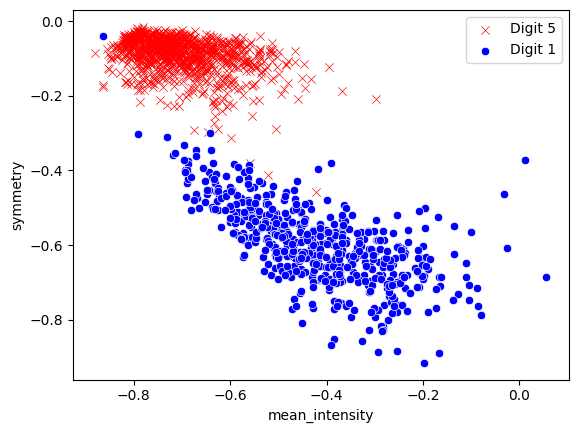

In [6]:
#Plot digit 5 and digit 1 labels
f, ax = plt.subplots()
sns.scatterplot(data = train[train['label'] == 1], x = 'mean_intensity', y = 'symmetry', marker='x', color='red', label='Digit 5')
sns.scatterplot(data = train[train['label'] == 5], x = 'mean_intensity', y = 'symmetry', marker='o', color='blue', label='Digit 1')
plt.show()

In [7]:
x = train[['mean_intensity','symmetry']].to_numpy()
y = train['label'].apply(lambda x: 1 if x==1 else -1).to_numpy()
w = np.random.uniform(low=1, high=1, size=x.shape[1])
#w = np.array([-0.3, 1.2])
def gradient_e_in(w, x, y):
    wTx = x @ w
    sigmoid = np.exp(-y * wTx)/(1+np.exp(-y * wTx))
    y = y[:, np.newaxis]
    sigmoid = sigmoid[:, np.newaxis]
    grad = -np.sum((y * x) * sigmoid, axis=0)/(x.shape[0])
    return grad

def e_in(w, x, y):
    y = y[:, np.newaxis]
    wTx = x @ w
    ein = np.sum(np.log(1 + np.exp(-y * wTx)))/(x.shape[0])
    return ein

def logistic_regression(w, x, y, eta, iterations):
    min_loss_weights = np.zeros(x.shape[1])
    ein = float('inf')
    for _ in range(iterations):
        grad = gradient_e_in(w,x,y)
        loss = e_in(w,x,y)
        if(ein > loss):
            ein = loss
            min_loss_weights = w.copy()
        w += eta*-grad
    return min_loss_weights

w_optimal = logistic_regression(w,x,y,0.1,500)

In [8]:
w_optimal

array([-1.03812075,  1.51090273])

In [9]:
e_in(w_optimal, x, y)

np.float64(1098.3545575841324)

In [10]:
#Calculate in sample accuracy
sigmoid = lambda w,x: np.exp(x @ w)/(1+np.exp(x @ w))
in_sample_predictions = sigmoid(w, x)
print(in_sample_predictions)
in_sample_predictions = np.where(in_sample_predictions >= 0.5, 1, -1)

y_true = train['label'].apply(lambda x: 1 if x==1 else -1).to_numpy()
in_sample_accuracy = np.mean(in_sample_predictions == y_true)
in_sample_accuracy

[0.1022395  0.85260966 0.84617628 ... 0.75556162 0.82632749 0.69385041]


np.float64(0.9628443305573351)

In [12]:
# Set up test
test['mean_intensity'] = test['img'].apply(lambda x: np.mean(x))
test['symmetry'] = test['img'].apply(lambda x: -np.mean([np.abs(x-np.flip(x,axis=1)), np.abs(x-np.flip(x,axis=0))]))

x_test = test[['mean_intensity', 'symmetry']].to_numpy()
out_sample_predictions = sigmoid(w_optimal, x_test)
print(out_sample_predictions)
out_sample_predictions = np.where(out_sample_predictions >= 0.5, 1, -1)

y_true = test['label'].apply(lambda x: 1 if x==1 else -1).to_numpy()
out_sample_predictions = np.mean(out_sample_predictions == y_true)
out_sample_predictions

[0.38321194 0.44741594 0.42633921 ... 0.35059467 0.40123644 0.62203597]


np.float64(0.8220338983050848)